![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face recognition
Task is to recognize a faces

### Dataset
**Aligned Face Dataset from Pinterest**

This dataset contains 10.770 images for 100 people. All images are taken from 'Pinterest' and      aligned using dlib library.

In [ ]:
import tensorflow
tensorflow.__version__

# Extract content from zipfile
from zipfile import ZipFile

# Imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt, sklearn, re, random
from tqdm.notebook import tqdm
%matplotlib inline

# Model
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from sklearn.svm import SVC

# Encode, standardize and PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

#### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Change current working directory to project folder (2 marks)

In [ ]:
# Setting the current working directory
import os; os.chdir('drive/My Drive/Colab Notebooks/Great Learning/Project 2 - Advanced Computer Vision - Face Recognition')

### Extract the zip file (3 marks)
- Extract Aligned Face Dataset from Pinterest.zip

In [ ]:
with ZipFile('Aligned Face Dataset from Pinterest.zip', 'r') as zip:
  zip.extractall()

### Function to load images
- Define a function to load the images from the extracted folder and map each image with person id 


In [ ]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')
labels = np.array([meta.name for meta in metadata])

### Define function to load image
- Define a function to load image from the metadata

In [ ]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

#### Load a sample image (3 marks)
- Load one image using the function "load_image"

In [ ]:
n = np.random.randint(1, len(metadata))
img_path = metadata[n].image_path()
img = load_image(img_path)

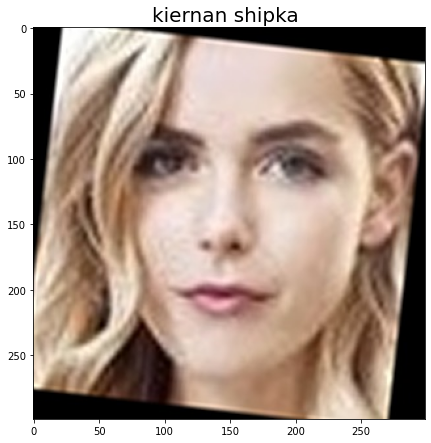

In [ ]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
title = labels[n].split('_')[1]
ax.set_title(title, fontsize = 20)
_ = plt.imshow(img)

### VGG Face model
- Here we are giving you the predefined model for VGG face

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    #Clear out tensorflow memory
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

#### Load the model (3 marks)
- Load the model defined above
- Then load the given weight file named "vgg_face_weights.h5"

In [ ]:
model = vgg_face()
model.load_weights('vgg_face_weights.h5')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

### Get vgg_face_descriptor

In [ ]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

### Generate embeddings for each image in the dataset
- Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model. 

In [ ]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


### Generate embeddings for all images (8 marks)
- Write code to iterate through metadata and create embeddings for each image using `vgg_face_descriptor.predict()` and store in a list with name `embeddings`

- If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.

In [ ]:
embeddings = []
embeddings = np.zeros((metadata.shape[0], 2622))
for i, meta in tqdm(enumerate(metadata)):
  try:
    image = load_image(str(meta))
    image = (image/255.).astype(np.float32)
    image = cv2.resize(image, (224, 224))
    embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(image, axis = 0))[0]
  except:
    embeddings[i] = np.zeros(2622)

### Function to calculate distance between given 2 pairs of images.

- Consider distance metric as "Squared L2 distance"
- Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [ ]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

#### Plot images and get distance between the pairs given below
- 2, 3 and 2, 180
- 30, 31 and 30, 100
- 70, 72 and 70, 115

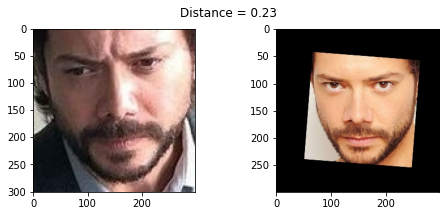

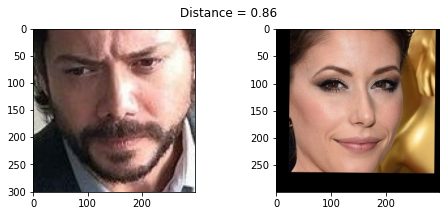

In [ ]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)

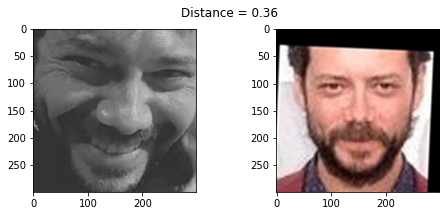

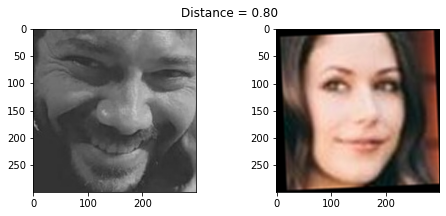

In [ ]:
show_pair(30, 31)
show_pair(30, 100)

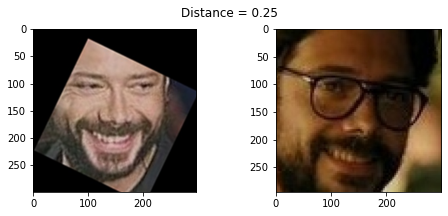

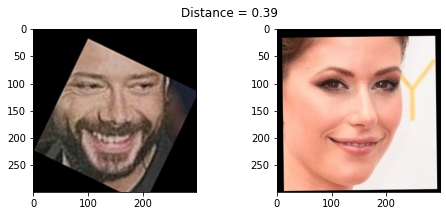

In [ ]:
show_pair(70, 72)
show_pair(70, 115)

### Create train and test sets (8 marks)
- Create X_train, X_test and y_train, y_test
- Use train_idx to seperate out training features and labels
- Use test_idx to seperate out testing features and labels

In [ ]:
#every 9th example goes in test data and rest go in train data
train_idx = np.arange(metadata.shape[0]) % 9 != 0     
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
X_test = np.array(embeddings)[test_idx]

# Labels
y_train = np.array([meta.name for meta in metadata[train_idx]])
y_test = np.array([meta.name for meta in metadata[test_idx]])

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9488, 2622) (1187, 2622) (9488,) (1187,)


### Encode the Labels (4 marks)
- Encode the targets
- Use LabelEncoder

In [ ]:
from sklearn.preprocessing import LabelEncoder
en = LabelEncoder()
y_train = en.fit_transform(y_train)
y_test = en.transform(y_test)
#### Add your code here ####

### Standardize the feature values (4 marks)
- Scale the features using StandardScaler

In [ ]:
# Standarize features
from sklearn.preprocessing import StandardScaler

#### Add your code here ####
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

### Reduce dimensions using PCA (4 marks)
- Reduce feature dimensions using Principal Component Analysis
- Set the parameter n_components=128

In [ ]:
from sklearn.decomposition import PCA

#### Add your code here ####
pca = PCA(n_components=128, svd_solver = 'full', whiten = True)
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)

In [ ]:
df = pd.DataFrame(data = X_train_pca)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,-0.535426,-0.755988,-0.857061,0.593532,-0.499307,0.196622,-0.503879,-0.258289,1.068682,0.399567,-0.648842,-1.095569,-0.007382,-0.288320,0.790377,0.942435,0.197687,-0.318746,0.090134,0.845105,-0.514057,-0.539930,-0.322694,0.685565,0.580180,0.080552,2.482437,-0.409784,-0.033357,0.849767,-0.534448,0.535243,-0.060243,-0.102407,-1.584464,0.047269,0.508122,-0.703703,-0.985088,-0.232641,...,-0.121225,-0.609204,1.394521,-0.648992,-0.023510,-0.263450,0.547788,-1.319196,-0.396186,-0.085046,-0.761989,-0.106086,-0.574844,-1.442704,1.103186,0.042372,-0.839048,1.306962,0.408533,0.198755,-2.514136,-0.108846,-0.353531,0.682927,1.202569,0.579260,0.344364,-0.719319,-0.799272,0.171113,-0.565371,-0.616690,0.266848,0.581683,-0.299594,-1.323479,0.177203,-0.605651,0.462660,-1.133849
1,-0.825682,1.516994,-0.747972,2.042083,0.825508,1.383699,-0.275687,-0.952164,1.447967,0.179494,-1.332186,-1.466594,-0.523415,0.976315,-0.266758,0.704629,1.084553,-1.745853,2.220719,1.694276,-1.267022,1.148404,0.235792,0.081612,0.852391,-0.794483,5.319830,0.396378,0.624682,0.976881,-0.956919,-0.395870,-1.307960,0.314526,-2.285338,0.414762,0.898423,-1.421122,0.823477,0.795273,...,2.636772,-1.863659,0.354292,-2.620202,-0.617300,-0.739907,0.624328,-0.904051,0.700270,0.170113,-1.507064,-0.219702,-0.064797,-1.891039,0.554849,-1.190540,-0.090890,1.754739,1.802108,-1.624354,-1.240063,0.194011,-0.094685,-0.442871,0.167876,1.593620,3.118574,-0.287485,-0.174747,-1.047882,-0.603248,-0.911722,-0.270133,0.540527,-0.841290,-1.649417,-0.158201,-1.540601,1.444094,-3.003720
2,-0.919630,-0.082118,-0.683492,0.680290,-0.889986,1.084528,-0.335827,-0.429198,1.121029,0.261839,-0.485125,-1.276021,0.339285,0.380515,-0.017450,0.015453,0.311884,-1.522821,0.100351,-0.147316,-0.419166,0.525218,0.260391,0.153726,1.046753,-0.410934,3.449671,-0.211057,-0.212308,0.913679,-1.316978,0.134456,-0.091374,-1.071701,-1.764545,0.116912,1.002827,-0.682427,0.865224,0.102613,...,1.137927,-1.327897,0.543852,-1.048740,-0.595407,-0.849190,0.965526,-1.951708,-0.247628,0.048324,-1.585006,0.045730,-0.364594,-0.033801,0.954972,-0.875437,0.059720,1.112768,1.773815,0.196152,-1.319402,-0.326172,0.598535,-0.442526,0.898634,1.448117,1.480374,1.095615,0.612159,-1.394402,-0.722379,-0.189617,-1.107206,0.853178,-0.350213,-1.661901,-0.683395,-0.537274,1.354584,-2.862079
3,-0.906446,-0.831591,-0.656684,0.655000,-0.830579,0.743491,0.607723,0.455094,0.559577,-0.194810,-0.559833,-0.149958,-0.693713,0.440883,-0.319385,1.087698,-0.379202,-1.593064,-0.310756,0.547818,0.327744,0.223669,-1.105495,0.870066,0.896845,0.615932,2.264065,-0.161157,0.667700,1.579063,-0.478605,-0.765610,0.307366,1.013755,-1.649550,-0.034970,0.598909,-1.001083,1.046404,1.366710,...,0.437776,-0.848940,-0.203455,-1.659920,0.196952,-0.550957,-0.413993,-0.544451,0.456089,0.749252,-1.045639,0.278606,-1.301886,-0.667006,-0.121713,-0.901440,0.802486,0.021045,1.170999,-1.114203,0.265828,-1.222954,0.947547,-0.673007,0.114596,0.203839,2.147158,0.939789,0.691636,-0.832453,-0.581471,0.029255,-0.015410,-0.869157,-0.835902,-1.602685,0.140498,0.683110,-0.088752,-1.383231
4,-1.333719,0.160295,0.087087,0.719711,-0.439413,1.725416,0.534213,0.056262,1.616875,0.100650,-0.610412,-0.885744,-0.102859,1.551268,-0.174085,0.604868,0.199885,-2.513381,-0.408383,0.343531,0.581272,0.127183,-1.366772,0.244995,0.525167,0.967901,2.894929,-0.657399,0.870292,1.765456,-0.506028,-1.888039,0.027084,0.300423,-1.901109,1.088588,0.902959,0.150848,0.825994,2.004440,...,-0.023372,-1.917488,0.719034,-2.285721,-0.136316,-1.677522,-0.291864,-0.337818,-0.425883,2.076122,-2.455071,0.241414,-1.675847,-0.881830,-0.477877,-1.312344,0.976957,0.540519,1.551241,0.084680,-1.795910,-2.036701,1.219228,0.197735,0.458035,0.542511,2.295281,1.530367,-0.290187,-1.13

### Build a Classifier (4 marks)
- Use SVM Classifier to predict the person in the given image
- Fit the classifier and print the score

In [ ]:
from sklearn.svm import SVC
svc_pca = SVC(C = 1, gamma = 0.001, kernel = 'rbf', random_state = 42)
svc_pca.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_pca, y_train)))

SVC accuracy for train set: 0.976


In [ ]:
# Predict
y_pred = svc_pca.predict(X_test_pca)

# Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred).round(3)))

Accuracy Score: 0.962


In [ ]:
names = [name.split('_')[1].title().strip() for name in labels]

# Classification Report
print('Classification Report: \n{}'.format(classification_report(y_test, y_pred, target_names = np.unique(names))))

Classification Report: 
                          precision    recall  f1-score   support

      Alexandra Daddario       1.00      1.00      1.00        10
            Alvaro Morte       1.00      0.92      0.96        13
Alycia Debnam Carey Face       1.00      1.00      1.00        12
             Amanda Crew       1.00      1.00      1.00         8
          Amaury Nolasco       1.00      0.89      0.94         9
        Amber Heard Face       1.00      0.86      0.92         7
               Anna Gunn       0.88      0.93      0.90        15
           Anne Hathaway       0.93      1.00      0.96        13
     Barbara Palvin Face       1.00      0.78      0.88         9
      Bellamy Blake Face       1.00      1.00      1.00        14
    Benedict Cumberbatch       1.00      1.00      1.00        12
            Betsy Brandt       1.00      1.00      1.00        10
              Bill Gates       0.89      0.89      0.89         9
        Brenton Thwaites       1.00      1.00      

### Test results (2 mark)
- Take 10th image from test set and plot the image
- Report to which person(folder name in dataset) the image belongs to

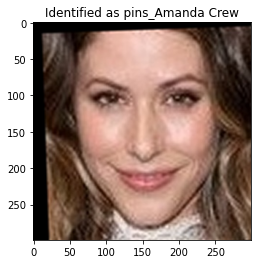

In [ ]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 10

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = svc_pca.predict([X_test_pca[example_idx]])
example_identity = en.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');